In [1]:
import numpy as np
import os
import cv2
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.layers import Input, Embedding, Dense, Dropout, Flatten
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D
from keras.models import Model
import imutils
%matplotlib inline
import math
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as pl
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split,KFold
image_size1 = 85
image_size2 = 128

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [23]:
#Function to load image data
def load_train(simul=None):
    X_train = []
    y_train = []
    train_ds = pd.read_csv('Train.csv')
    print('Read train images')
    for index, row in train_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        imag1 = img.transpose((2,0,1))
        X_train.append(imag1)
        if simul == 0:
#             print(row['Competency_Score'])
            y_train.append(row['Competency_Score'])
        elif simul == 1:
            y_train.append(row['Trustworthy_Score'])
        else:    
            y_train.append([row['Competency_Score'],row['Trustworthy_Score']])   
        simul = simul     
        #Zoom image
        X_train,y_train = zoom(simul = simul,img = img,X_train = X_train,y_train = y_train,row= row)
        #Rotations
        X_train,y_train = rotation(simul = simul,img = img,X_train = X_train,y_train = y_train, row = row)
    return X_train,y_train

#Read & Normalize data
def read_and_normalize_train_data(simul = None):
    simul = simul 
    train_data, train_target = load_train(simul = simul)
#     print(train_target)
    train_data = np.array(train_data, dtype=np.float32)
    train_target = np.array(train_target, dtype=np.float32)
    train_target = np.array(train_target, dtype=object)
    # normalize inputs from 0-255 to 0-1
    train_data = train_data / 255
    size = len(train_data)
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target,size

#Zoom image
def zoom(simul,img,X_train,y_train,row):
    zoom_pix = 4
    zoom_factor = 1 + (2*zoom_pix)/image_size2
    image = cv2.resize(img, None, fx=zoom_factor,fy=zoom_factor, interpolation=cv2.INTER_LINEAR)
    top_crop = (image.shape[0] - image_size2)//2
    left_crop = (image.shape[1] - image_size1)//2
    zoomed = image[top_crop: top_crop+image_size2,left_crop: left_crop+image_size1]
    zoomed = np.moveaxis(zoomed, -1, 0)
    X_train.append(zoomed)
    if simul == 0:
        y_train.append(row['Competency_Score'])
    elif simul == 1:
        y_train.append(row['Trustworthy_Score'])
    else:    
         y_train.append([row['Competency_Score'],row['Trustworthy_Score']]) 
    return X_train,y_train

#Rotations
def rotation(simul,img,X_train,y_train,row):
    for angle in np.arange(0, 360, 120):
        (h, w) = img.shape[:2]
        center = (w / 2, h / 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(img, M, (w, h))
        rotated = np.moveaxis(rotated, -1, 0)
        X_train.append(rotated)
        if simul == 0:
            y_train.append(row['Competency_Score'])
        elif simul == 1:
            y_train.append(row['Trustworthy_Score'])
        else:    
            y_train.append([row['Competency_Score'],row['Trustworthy_Score']]) 
    return X_train, y_train

# Creation of model 
def create_model(config,output):
    if config == 1:
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(16, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)
        x = Conv2D(32, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)
        x = Conv2D(64, 3,activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x) 
        x = Flatten()(x)     
        x = Dense(500, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(100, activation='relu')(x)
        x = Dropout(0.25)(x)
        x = Dense(20, activation='relu')(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae','acc'])
        return model
    elif config == 2: 
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(32, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)
        x = Flatten()(x)     
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae','acc'])
        return model
    elif config == 3:
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(32, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)       
#         x = BatchNormalization(axis= 3)  
        x = Conv2D(64, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)        
#         x = BatchNormalization(axis= 3)    
        x = Conv2D(128, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)        
#         x = BatchNormalization(axis = 3)(x)
        x = Conv2D(64, 3, activation='relu')(x)
        x = GlobalAveragePooling2D()(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    
#Training Model    
def train_model(batch_size = 50, nb_epoch = 5,simul = None,Output = 2,config = 1):     
    train_data, train_target,size = read_and_normalize_train_data(simul = simul)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    model = create_model(config = 1, output = Output)
    for j, (train_idx, val_idx) in enumerate(kfold.split(train_data, train_target)):
        print('\nFold ',j)
        X_train_cv = train_data[train_idx]
        y_train_cv = train_target[train_idx]
        X_valid_cv = train_data[val_idx]
        y_valid_cv = train_target[val_idx] 
        name_weights = "final_model_fold" + str(j) + "_weights.h5"
        model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
        checkpoint = ModelCheckpoint(name_weights,monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
        earlystopping = EarlyStopping(monitor='val_loss',patience=5, verbose=1, mode='auto', restore_best_weights=True)
        callbacks_list = [checkpoint,earlystopping]
        model.fit(X_train_cv, y_train_cv, batch_size=batch_size,epochs=nb_epoch,callbacks=callbacks_list,verbose=1, validation_data=(X_valid_cv, y_valid_cv))
        score = model.evaluate(X_valid_cv, y_valid_cv)
        print(model.metrics_names)
        print('Test score:', score)        
    return model

# Simultaneous Regression

In [4]:
model = train_model(batch_size = 50, nb_epoch = 5,simul = None,Output = 2,config = 1)

Read train images
Train shape: (4000, 3, 128, 85)
4000 train samples

Fold  0
Train on 3200 samples, validate on 800 samples
Epoch 1/5
3200/3200 [==============================] - 250s 78ms/step - loss: 7.2356 - mean_absolute_error: 2.1231 - val_loss: 3.9892 - val_mean_absolute_error: 1.6200

Epoch 00001: val_loss improved from inf to 3.98921, saving model to final_model_fold0_weights.h5
Epoch 2/5
3200/3200 [==============================] - 315s 98ms/step - loss: 4.8192 - mean_absolute_error: 1.7651 - val_loss: 3.5331 - val_mean_absolute_error: 1.5262

Epoch 00002: val_loss improved from 3.98921 to 3.53310, saving model to final_model_fold0_weights.h5
Epoch 3/5
3200/3200 [==============================] - 318s 99ms/step - loss: 4.4437 - mean_absolute_error: 1.7081 - val_loss: 3.2558 - val_mean_absolute_error: 1.4600

Epoch 00003: val_loss improved from 3.53310 to 3.25580, saving model to final_model_fold0_weights.h5
Epoch 4/5
3200/3200 [==============================] - 271s 85ms/step

In [8]:
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a) 
# Test Results
a = np.array(y)
a = a.reshape(-1,2)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results['Combined Test Score'] = y
df_results[['Competency_Score_P','Trustworthy_Score_P']] = pd.DataFrame(a)
df_results['Competency_Score_P'] = round(df_results['Competency_Score_P'], 2)
df_results['Trustworthy_Score_P'] = round(df_results['Trustworthy_Score_P'], 2)
df_results['Competency_Score_A'] = test_ds['Competency_Score']
df_results['Trustworthy_Score_A'] = test_ds['Trustworthy_Score']
df_results = df_results[['Image_Name', 'Competency_Score_P', 'Trustworthy_Score_P','Competency_Score_A','Trustworthy_Score_A']]
mae_comp = np.sum(np.absolute(df_results['Competency_Score_P'] - df_results['Competency_Score_A']))/len(df_results)
mae_trust = np.sum(np.absolute(df_results['Trustworthy_Score_P'] - df_results['Trustworthy_Score_A']))/len(df_results)
print("MAE Competency:", mae_comp)
print("MAE Trustworthy:", mae_trust)
print("MAE Combined:", mae_trust+mae_comp)


MAE Competency: 2.5795522408698925
MAE Trustworthy: 2.4684328247184184
MAE Combined: 5.0479850655883105


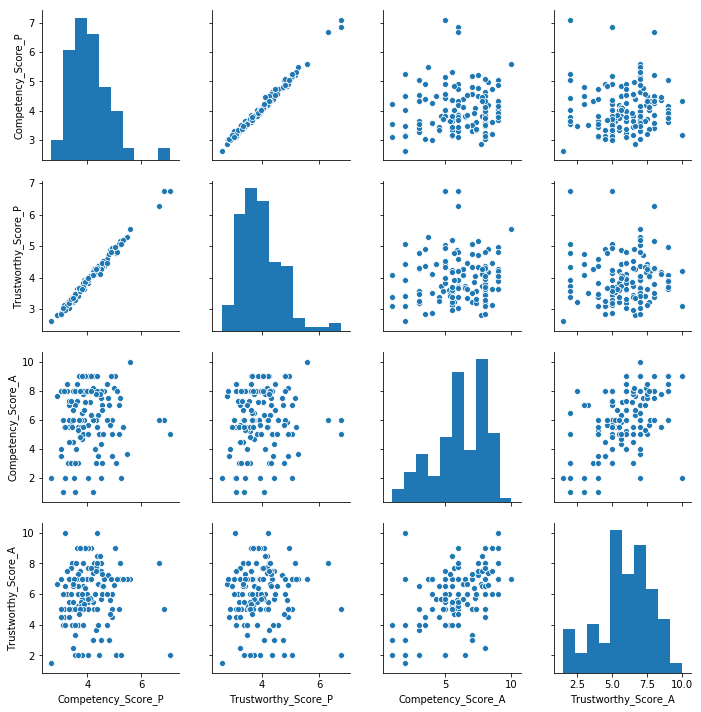

In [9]:
sns.pairplot(df_results)

# Individual Regression - Only on Competency Score

In [24]:
model = train_model(batch_size = 50, nb_epoch = 5,simul = 0,Output = 1,config = 1)

Read train images
Train shape: (4000, 3, 128, 85)
4000 train samples

Fold  0
Train on 3200 samples, validate on 800 samples
Epoch 1/5
3200/3200 [==============================] - 200s 63ms/step - loss: 10.7961 - mean_absolute_error: 2.4835 - val_loss: 4.3770 - val_mean_absolute_error: 1.6975

Epoch 00001: val_loss improved from inf to 4.37703, saving model to final_model_fold0_weights.h5
Epoch 2/5
3200/3200 [==============================] - 200s 62ms/step - loss: 5.3404 - mean_absolute_error: 1.8545 - val_loss: 3.2610 - val_mean_absolute_error: 1.4612

Epoch 00002: val_loss improved from 4.37703 to 3.26099, saving model to final_model_fold0_weights.h5
Epoch 3/5
3200/3200 [==============================] - 199s 62ms/step - loss: 4.9688 - mean_absolute_error: 1.7900 - val_loss: 3.4369 - val_mean_absolute_error: 1.4990

Epoch 00003: val_loss did not improve from 3.26099
Epoch 4/5
3200/3200 [==============================] - 197s 62ms/step - loss: 4.5847 - mean_absolute_error: 1.7289 - v

  Image_Name  Competency_Score_P  Competency_Score_A
0   B268.jpg                2.77                3.00
1   B287.jpg                5.27                8.00
2   B467.jpg                2.61                7.67
3   B506.jpg                2.69                5.88
4   B292.jpg                2.48                9.00
MAE Competency: 3.2696268673085456


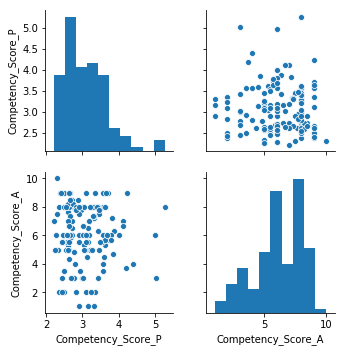

In [25]:
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a)
        # Test Results
a = np.array(y)
a = a.reshape(-1,1)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results[['Competency_Score_P']] = pd.DataFrame(a)
df_results['Competency_Score_P'] = round(df_results['Competency_Score_P'], 2)
df_results['Competency_Score_A'] = test_ds['Competency_Score']
df_results = df_results[['Image_Name', 'Competency_Score_P','Competency_Score_A']]
print(df_results.head(5))
mae_comp = np.sum(np.absolute(df_results['Competency_Score_P'] - df_results['Competency_Score_A']))/len(df_results)
print("MAE Competency:", mae_comp)
sns.pairplot(df_results)

# Individual Regression - Only on Trustworthy Score

In [26]:
model = train_model(batch_size = 50, nb_epoch = 5,simul = 1,Output = 1,config = 1)

Read train images
Train shape: (4000, 3, 128, 85)
4000 train samples

Fold  0
Train on 3200 samples, validate on 800 samples
Epoch 1/5
3200/3200 [==============================] - 204s 64ms/step - loss: 8.2542 - mean_absolute_error: 2.1886 - val_loss: 4.1509 - val_mean_absolute_error: 1.6623

Epoch 00001: val_loss improved from inf to 4.15085, saving model to final_model_fold0_weights.h5
Epoch 2/5
3200/3200 [==============================] - 202s 63ms/step - loss: 5.0422 - mean_absolute_error: 1.8172 - val_loss: 3.5425 - val_mean_absolute_error: 1.5164

Epoch 00002: val_loss improved from 4.15085 to 3.54250, saving model to final_model_fold0_weights.h5
Epoch 3/5
3200/3200 [==============================] - 202s 63ms/step - loss: 4.5558 - mean_absolute_error: 1.7225 - val_loss: 3.4300 - val_mean_absolute_error: 1.5055

Epoch 00003: val_loss improved from 3.54250 to 3.43001, saving model to final_model_fold0_weights.h5
Epoch 4/5
3200/3200 [==============================] - 203s 63ms/step

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

  Image_Name  Trustworthy_Score_P  Trustworthy_Score_A
0   B268.jpg                 3.82                 5.00
1   B287.jpg                 3.56                 2.50
2   B467.jpg                 3.17                 6.67
3   B506.jpg                 3.60                 5.62
4   B292.jpg                 2.95                 9.00
MAE Trustworthy: 2.6396268609744395


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


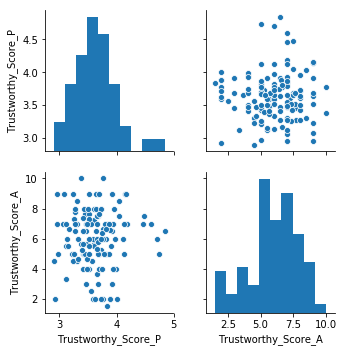

In [28]:
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a)
        # Test Results
a = np.array(y)
a = a.reshape(-1,1)
df_results['Image_Name'] = x
df_results[['Trustworthy_Score_P']] = pd.DataFrame(a)
df_results['Trustworthy_Score_P'] = round(df_results['Trustworthy_Score_P'], 2)
df_results['Trustworthy_Score_A'] = test_ds['Trustworthy_Score']
df_results = df_results[['Image_Name','Trustworthy_Score_P','Trustworthy_Score_A']]
print(df_results.head(5))
mae_trust = np.sum(np.absolute(df_results['Trustworthy_Score_P'] - df_results['Trustworthy_Score_A']))/len(df_results)
print("MAE Trustworthy:", mae_trust)
sns.pairplot(df_results)

# Final Test

In [ ]:
model = create_model(config = 1, output = 2)
filepath="final_model_fold0_weights.h5"
model.load_weights(filepath)
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a)  

In [ ]:
# Test Results
a = np.array(y)
a = a.reshape(-1,2)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results['Combined Test Score'] = y
df_results[['Competency_Score_P','Trustworthy_Score_P']] = pd.DataFrame(a)
df_results['Competency_Score_P'] = round(df_results['Competency_Score_P'], 2)
df_results['Trustworthy_Score_P'] = round(df_results['Trustworthy_Score_P'], 2)
df_results['Competency_Score_A'] = test_ds['Competency_Score']
df_results['Trustworthy_Score_A'] = test_ds['Trustworthy_Score']
df_results = df_results[['Image_Name', 'Competency_Score_P', 'Trustworthy_Score_P','Competency_Score_A','Trustworthy_Score_A']]


In [ ]:
df_results.head(5)

In [ ]:
sns.pairplot(df_results)

In [ ]:
#Fold 0


In [ ]:
#Fold 1
mae_comp = np.sum(np.absolute(df_results['Competency_Score_P'] - df_results['Competency_Score_A']))/len(df_results)
mae_trust = np.sum(np.absolute(df_results['Trustworthy_Score_P'] - df_results['Trustworthy_Score_A']))/len(df_results)
print("MAE Competency:", mae_comp)
print("MAE Trustworthy:", mae_trust)
print("MAE Combined:", mae_trust+mae_comp)

In [ ]:
#Fold2
mae_comp = np.sum(np.absolute(df_results['Competency_Score_P'] - df_results['Competency_Score_A']))/len(df_results)
mae_trust = np.sum(np.absolute(df_results['Trustworthy_Score_P'] - df_results['Trustworthy_Score_A']))/len(df_results)
print("MAE Competency:", mae_comp)
print("MAE Trustworthy:", mae_trust)
print("MAE Combined:", mae_trust+mae_comp)

In [ ]:
#Fold3
mae_comp = np.sum(np.absolute(df_results['Competency_Score_P'] - df_results['Competency_Score_A']))/len(df_results)
mae_trust = np.sum(np.absolute(df_results['Trustworthy_Score_P'] - df_results['Trustworthy_Score_A']))/len(df_results)
print("MAE Competency:", mae_comp)
print("MAE Trustworthy:", mae_trust)
print("MAE Combined:", mae_trust+mae_comp)